<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(74662,)
Epoch 1/5
292/292 [==============================] - 110s 378ms/step - loss: 159.8652 - mae: 160.1699
Epoch 2/5
292/292 [==============================] - 116s 396ms/step - loss: 167.3184 - mae: 167.9325
Epoch 3/5
292/292 [==============================] - 119s 409ms/step - loss: 168.8777 - mae: 169.4937
Epoch 4/5
292/292 [==============================] - 119s 408ms/step - loss: 169.5502 - mae: 170.1664
Epoch 5/5
292/292 [==============================] - 120s 410ms/step - loss: 177.5922 - mae: 178.1958


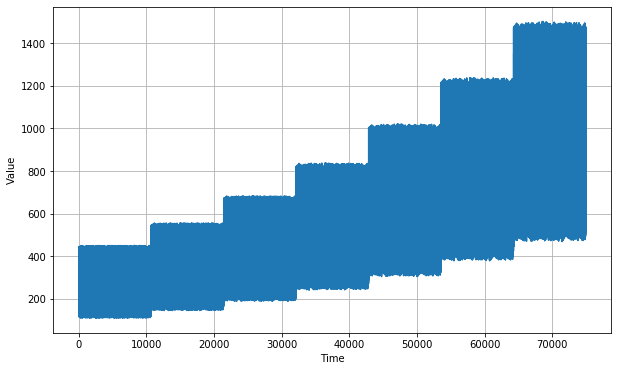

In [2]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

time_step = []
temps = []
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
q = pd.read_csv("Diuresis_TR.csv")
step=0
for i in range(1,8):
    for j in range(10714):
        temps.append(float(q.iloc[j, i]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

split_time = 74662
time_train = time[:74662]
x_train = series[:74662]
time_valid = time[74662:]
x_valid = series[74662:]

window_size = 64
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=5, callbacks=[lr_schedule])

[1e-08, 0.1, 50, 300]

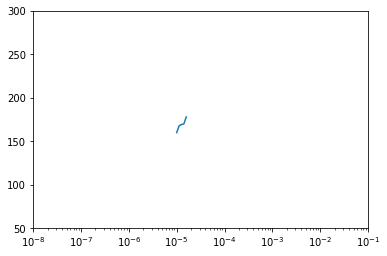

In [3]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 50, 300])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
2/2 [==============================] - 9s 5s/step - loss: 261.2705 - mae: 270.0876
Epoch 2/50
2/2 [==============================] - 0s 245ms/step - loss: 191.5511 - mae: 185.4718
Epoch 3/50
2/2 [==============================] - 0s 232ms/step - loss: 114.3486 - mae: 111.8819
Epoch 4/50
2/2 [==============================] - 0s 207ms/step - loss: 84.8169 - mae: 85.7207
Epoch 5/50
2/2 [==============================] - 0s 222ms/step - loss: 93.3629 - mae: 94.6362
Epoch 6/50
2/2 [==============================] - 0s 238ms/step - loss: 96.8132 - mae: 96.5574
Epoch 7/50
2/2 [==============================] - 0s 231ms/step - loss: 81.3214 - mae: 81.4237
Epoch 8/50
2/2 [==============================] - 0s 232ms/step - loss: 82.4210 - mae: 82.9210
Epoch 9/50
2/2 [==============================] - 0s 245ms/step - loss: 79.7062 - mae: 79.7055
Epoch 10/50
2/2 [==============================] - 1s 260ms/step - loss: 79.2240 - mae: 79.8181
Epoch 11/50
2/2 [=============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print(rnn_forecast)

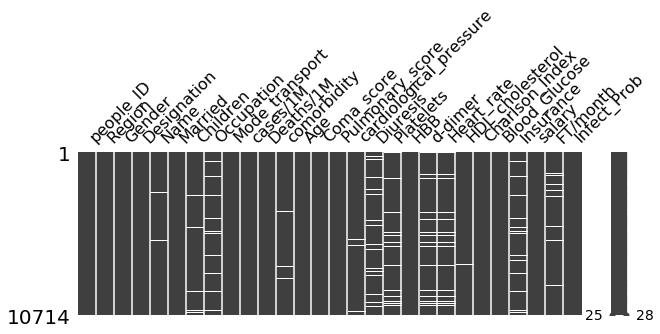

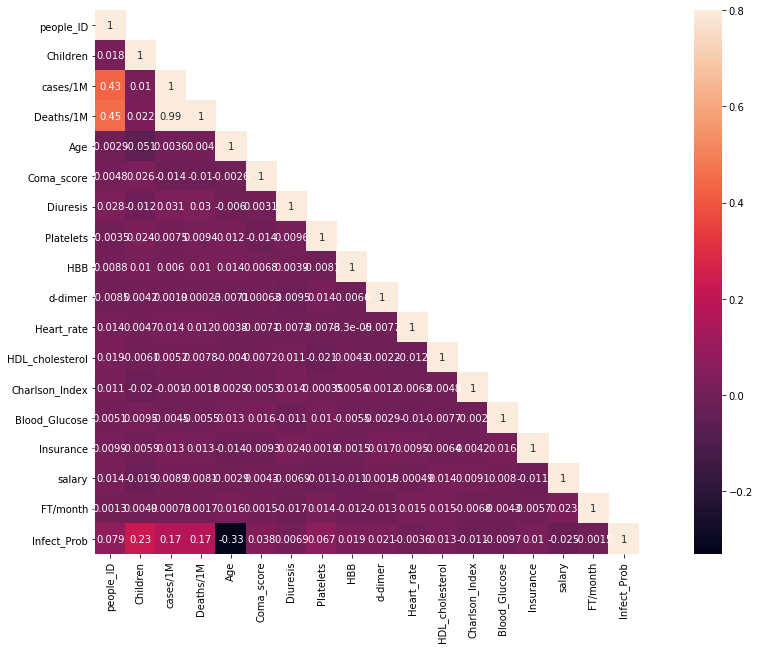

In [6]:
msno.matrix(df, figsize = (10,3))


corr_mat = df.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr_mat, mask = mask, vmax = 0.8, square = True, annot = True)

Mean Absolute Error: 4.452691294599341
Mean Squared Error: 77.61291832139126
Root Mean Squared Error: 8.809819426151211
0.28251019247118836


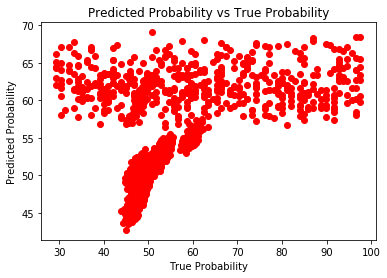

In [72]:
df.shape
X = df.iloc[:, [2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]]
#X = df.iloc[:, 1:-1]
y = df.iloc[: , -1]
pd.DataFrame(X).fillna(X.mean(), inplace=True)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)
cardiological_pressure=pd.get_dummies(X['cardiological_pressure'],drop_first=True)
Pulmonary_score=pd.get_dummies(X['Pulmonary_score'],drop_first=True)
comorbidity=pd.get_dummies(X['comorbidity'],drop_first=True)
Mode_transport=pd.get_dummies(X['Mode_transport'],drop_first=True)
Occupation=pd.get_dummies(X['Occupation'],drop_first=True)
Married=pd.get_dummies(X['Married'],drop_first=True)
Gender=pd.get_dummies(X['Gender'],drop_first=True)


# Drop the state coulmn                                   
X=X.drop('cardiological_pressure',axis=1)
X=X.drop('Pulmonary_score',axis=1)
X=X.drop('comorbidity',axis=1)
X=X.drop('Mode_transport',axis=1)
X=X.drop('Occupation',axis=1)
X=X.drop('Married',axis=1)
X=X.drop('Gender',axis=1)


# concat the dummy variables
X=pd.concat([X,cardiological_pressure],axis=1)
X=pd.concat([X,Pulmonary_score],axis=1)
X=pd.concat([X,comorbidity],axis=1)
X=pd.concat([X,Mode_transport],axis=1)
X=pd.concat([X,Occupation],axis=1)
X=pd.concat([X,Married],axis=1)
X=pd.concat([X,Gender],axis=1)


X = np.append(arr = np.ones((X.shape[0],1)), values = X, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

s = r2_score(y_test, y_pred)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(s)
plt.scatter(y_test, y_pred, c ='r')
plt.xlabel('True Probability')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability vs True Probability')
plt.show()

In [ ]:
print(__doc__)

###############################################################################
# Generate sample data
import numpy as np

#X = np.sort(5 * np.random.rand(40, 1), axis=0)
#y = np.sin(X).ravel()

###############################################################################
# Add noise to targets
#y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
from sklearn.svm import SVR
'''
svr_rbf = SVR(kernel='rbf', C=1e4, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e4)
svr_poly = SVR(kernel='poly', C=1e4, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results
import pylab as pl
pl.scatter(X, y, c='k', label='data')
pl.hold('on')
pl.plot(X, y_rbf, c='g', label='RBF model')
pl.plot(X, y_lin, c='r', label='Linear model')
pl.plot(X, y_poly, c='b', label='Polynomial model')
pl.xlabel('data')
pl.ylabel('target')
pl.title('Support Vector Regression')
pl.legend()
pl.show()
'''